# DistortionFlowNet - demo

(The model weights were saved using keras h5 package.  pip install h5py==2.10.0 works)

In [1]:
import os
import numpy as np
import scipy.ndimage as sc
import nibabel as nib
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import keras.backend as K

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([(

In [2]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

In [3]:
from utils import loadNiftiVol

In [4]:
from distEstimatorNet.preprocessInput import preprocessInputData
from distEstimatorNet.preprocessInput import normalizeInputVol
from distEstimatorNet.distEstimator import UpDownFlow
from utils import displayResults,vol2mosaic,displayFSLResults

 ### load example data

In [5]:
base_folder_test = './demoData/upDownDataTest'
vol1_up_fname = os.path.join(base_folder_test,"_001","up","up.nii.gz")
vol1_down_fname = os.path.join(base_folder_test,"_001","down","down.nii.gz")

(100, 100, 54)


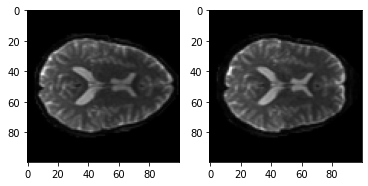

In [6]:
vol1_up =loadNiftiVol(vol1_up_fname)
vol1_down =loadNiftiVol(vol1_down_fname)
print(vol1_up.shape)
plt.figure()
plt.subplot(121);imshow(vol1_up[:,:,25],cmap="gray")
plt.subplot(122);imshow(vol1_down[:,:,25],cmap="gray")

#### combine up/down data into one 4d-array

In [7]:
Nx,Ny,Ns = vol1_up.shape
vol_UpDown = np.zeros((Nx,Ny,Ns,2))
vol_UpDown[:,:,:,0] = vol1_up
vol_UpDown[:,:,:,1] = vol1_down

#### normalize intensities of up/down volumes to [0,1] range

In [8]:
vol_UpDown, mean_tissue_signal = normalizeInputVol(vol_UpDown)

#### slice dimension comes first (slices are treated as data points during training)

In [9]:
vol_UpDown = np.transpose(vol_UpDown,(2,0,1,3))
print(vol_UpDown.shape)

(54, 100, 100, 2)


#### reshape volumes to 128x128 (that's the expected input size of the first layer)

In [10]:
testData = np.zeros((Ns,128,128,2))
for sl in range(Ns):
    testData[sl,:,:,0] = sc.zoom(vol_UpDown[sl,:,:,0],128/Nx)
    testData[sl,:,:,1] = sc.zoom(vol_UpDown[sl,:,:,1],128/Nx)

#### generate downsampled version of the 128x128 input images

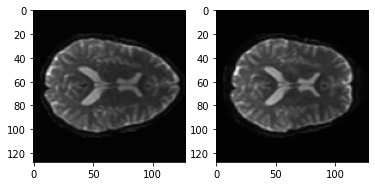

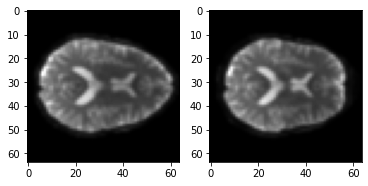

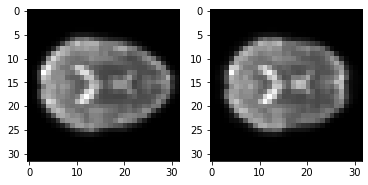

In [11]:
n_test_full,n_testN64,n_testN32 = preprocessInputData(testData)
inputTest = [n_test_full,n_testN64,n_testN32]
plt.figure()
plt.subplot(121);imshow(n_test_full[25,:,:,0],cmap="gray")
plt.subplot(122);imshow(n_test_full[25,:,:,1],cmap="gray")
plt.figure()
plt.subplot(121);imshow(n_testN64[25,:,:,0],cmap="gray")
plt.subplot(122);imshow(n_testN64[25,:,:,1],cmap="gray")
plt.figure()
plt.subplot(121);imshow(n_testN32[25,:,:,0],cmap="gray")
plt.subplot(122);imshow(n_testN32[25,:,:,1],cmap="gray")

### Construct the model and load weights

In [12]:
updownflow = UpDownFlow(architecture = 'SimpleFlowNet_v4', input_size=128, batchNormFlag=True)
folderName = 'v4_fullTraining_0611_lmba1_m4428'
full_file = os.path.join(".",folderName,"run_4.h5")
updownflow.load(full_file)

2022-06-07 13:31:07.409416: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA



done generating flownet v4
[(None, 64.0, 64.0, 2), (None, 32, 32, 2)]
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 128, 128, 2)  0                                            
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 16) 1584        main_input[0][0]                 
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 48          conv0[0][0]                      
__________________________________________________________________________________________________
layer0 (LeakyReLU)              (None, 128, 128, 16) 0           batch_normalization_1[0][0]      
______________________________________

### predict: the network expects a list of arrays with dimensions of 128x128, 64x64, 32x32 

In [13]:
prediction = updownflow.predict(inputTest)
out,out64,out32,vdm,vdm64,vdm32 = prediction

54/54 [==============================] - 4s 81ms/step


#### the output of the network consists of the multi-resolution arrays and the corresponding voxel displacememt maps
out is the main output with the blip up/down images that were corrected by applying the voxel displacement map (vdm)that the network found.

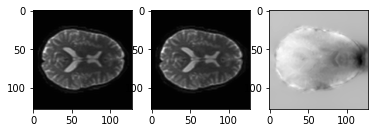

In [14]:
plt.figure()
plt.subplot(131);imshow(out[25,:,:,0],cmap="gray")
plt.subplot(132);imshow(out[25,:,:,1],cmap="gray")
plt.subplot(133);imshow(vdm[25,:,:,0],cmap="gray")

## (Re-) train model

### Construct the model

In [15]:
updownflow = UpDownFlow(architecture= 'SimpleFlowNet_v4',input_size = 128,batchNormFlag=True)
updownflow.config['w_tv'] = 0.05 # weight of total variation regularisation

done generating flownet v4
[(None, 64.0, 64.0, 2), (None, 32, 32, 2)]
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 128, 128, 2)  0                                            
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 16) 1584        main_input[0][0]                 
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 128, 128, 16) 48          conv0[0][0]                      
__________________________________________________________________________________________________
layer0 (LeakyReLU)              (None, 128, 128, 16) 0           batch_normalization_14[0][0]     
_______________________________________

### compile model using adam optimizer

In [16]:
updownflow.compileModel(learning_rate=0.001, w2=0.1, optimizer='adam')

using adam optimizer.



True

#### load the training and test data

In [17]:
trainData = []
for n in range(1,7):
    vol_up =loadNiftiVol(os.path.join(base_folder_test,f"_00{n}","up","up.nii.gz"))
    vol_down =loadNiftiVol(os.path.join(base_folder_test,f"_00{n}","down","down.nii.gz"))
    tmp_UpDown = np.stack([vol_up,vol_down],axis=3)
    tmp_UpDown, mean_tissue_signal = normalizeInputVol(tmp_UpDown)
    tmp_UpDown = np.transpose(tmp_UpDown,(2,0,1,3))
    nx = tmp_UpDown.shape[1]
    tmp = np.zeros((tmp_UpDown.shape[0],128,128,2))
    for sl in range(tmp_UpDown.shape[0]):
        tmp[sl,:,:,0] = sc.zoom(tmp_UpDown[sl,:,:,0],128/nx)
        tmp[sl,:,:,1] = sc.zoom(tmp_UpDown[sl,:,:,1],128/nx)
    if len(trainData) ==0:
        trainData = tmp
    else:
        trainData = np.concatenate((trainData,tmp),axis=0)   

In [18]:
testData = []
for n in range(7,10):
    vol_up =loadNiftiVol(os.path.join(base_folder_test,f"_00{n}","up","up.nii.gz"))
    vol_down =loadNiftiVol(os.path.join(base_folder_test,f"_00{n}","down","down.nii.gz"))
    tmp_UpDown = np.stack([vol_up,vol_down],axis=3)
    tmp_UpDown, mean_tissue_signal = normalizeInputVol(tmp_UpDown)
    tmp_UpDown = np.transpose(tmp_UpDown,(2,0,1,3))
    nx = tmp_UpDown.shape[1]
    tmp = np.zeros((tmp_UpDown.shape[0],128,128,2))
    for sl in range(tmp_UpDown.shape[0]):
        tmp[sl,:,:,0] = sc.zoom(tmp_UpDown[sl,:,:,0],128/nx)
        tmp[sl,:,:,1] = sc.zoom(tmp_UpDown[sl,:,:,1],128/nx)
    if len(testData) ==0:
        testData = tmp
    else:
        testData = np.concatenate((testData,tmp),axis=0) 

In [19]:
n_train_full,n_trainN64,n_trainN32 = preprocessInputData(trainData)
inputTrain = [n_train_full,n_trainN64,n_trainN32]

n_test_full,n_testN64,n_testN32 = preprocessInputData(testData)
inputTest = [n_test_full,n_testN64,n_testN32]

### run the optimizer
The network expects a list of numpy arrays as input, where the arrays are of dimension [Nt,128,128,2], [Nt,64,64,2] and [Nt,32,32,2]. Nt is the total number of training/test examples where each example corresponds to a blip up/down pair. \
This example is NOT meant to actually re-train the model. 

In [20]:
Nepochs = 10
hist_phasen=updownflow.train(inputTrain,inputTest,Nepochs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 439 samples, validate on 231 samples
Epoch 1/10
439/439 [==============================] - 194s 442ms/step - loss: 2.6694 - final_output_loss: 0.8192 - out64_loss: 1.0506 - out32_loss: 0.7843 - finalVDM_loss: 0.0113 - vdm64_loss: 0.0340 - vdm32_loss: 0.1064 - val_loss: 1.7527 - val_final_output_loss: 0.7730 - val_out64_loss: 0.5292 - val_out32_loss: 0.4426 - val_finalVDM_loss: 0.0078 - val_vdm64_loss: 0.0257 - val_vdm32_loss: 0.0458
Epoch 2/10
439/439 [==============================] - 187s 427ms/step - loss: 0.9686 - final_output_loss: 0.3373 - out64_loss: 0.3456 - out32_loss: 0.2810 - finalVDM_loss: 0.0086 - vdm64_loss: 0.0177 - vdm32_loss: 0.0210 - val_loss: 1.1533 - val_final_output_loss: 0.3996 - val_out64_loss: 0.3981 - val_out32_loss: 0.3487 - val_finalVDM_loss: 0.0066 - val_vdm64_loss: 0.0227 - val_vdm32_loss: 0.0389
Epoch 3/10
439/439 [==============================] - 185s 422ms/step - loss: 0.5300 - final_output_loss: 0.2627 - out64_loss: 0.1578 - out32_loss: 0.1065

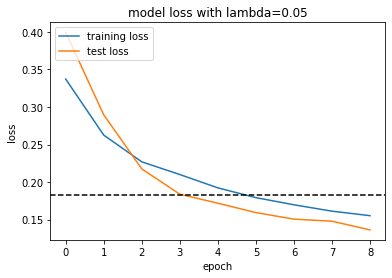

In [21]:
loss,valLoss = updownflow.plot_loss(1,0.183)

In [22]:
prediction_retrain = updownflow.predict(inputTest)

231/231 [==============================] - 18s 78ms/step


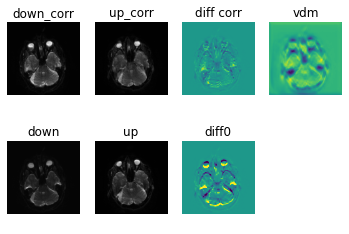

In [23]:
displayResults(prediction_retrain,inputTest,100)